<a href="https://colab.research.google.com/github/MichalKucko/FakeNews/blob/master/fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
%matplotlib inline

In [0]:
# kaskada to przebieg newsa zaczynający się od jednego węzła
class Cascade:
  def __init__(self, inode):
    self.alive = True   # kaskada umiera, gdy nie ma nowych czytelników
    self.cnt = [1]   # liczby wysłanych wiadomości w kolejnych iteracjach
    self.next = [inode]   # lista węzłów, do których news ma być przesłay w kolejnej iteracji
  
class News(ABC):
  def __init__(self, _id, _claim=True, _pers=0.5):
    self.id = _id   # temat newsa, np. 'okrągła Ziemia'
    self.claim = _claim   # czy news mówi, że to prawda
    self.pers = _pers   # persuasiveness (parametr a lub rho z artykułu)
    self.cascades = []   # lista kaskad, w których news jest przesyłany
    self.nAliveCascades = []   # liczba żywych kaskad
    self.influence = []   # lista średnich zmian poglądów wywołanych newsem w kolejnych iteracjach (zmiana = wartość bezwględna różnicy poglądu po i przed newsem)
    self.influenceCnt = []   # całkowita liczba ludzi, którzy zmienili poglądy pod wpływem newsa w kolejnych iteracjach
  
class RealNews(News):
  def __init__(self, _id, _claim=True, _pers=0.5):
    super().__init__(_id, _claim, _pers)
    self.prob = _pers if _claim == facts[_id] else 1 - _pers   # siła przekonywania newsa zależy od jego prawdziwości

class FakeNews(News):
  def __init__(self,_id,  _claim=True, _pers=0.5):
    super().__init__(_id, _claim, _pers)
    self.prob = _pers   # siła przekonywania newsa nie zależy od jego prawdziwości

In [0]:
class Agent(ABC):
  def __init__(self, _beliefs, _faith=np.random.uniform(), _confidence = np.random.uniform(), _dfaith=lambda: np.random.uniform()*0.2,
               _dconfidence=lambda: np.random.uniform()*0.2, _sociality= np.random.uniform ):
    self.beliefs = _beliefs   # poglądy - słownik {temat: liczba od 0 do 1}
    self.faith = _faith   # ogólna wiara w prawdziwość newsów
    self.confidence = _confidence   # ogólna pewność siebie (wiara we własne przekonania)
    self.dfaith = _dfaith   # o ile będzie mu się zwiększać / zmniejszać wiara, jak sprawdzi, że news kłamie
    self.dconfidence = _dconfidence   # o ile będzie mu się zwiększać / zmniejszać pewność siebie, jak news (nie) będzie się z nim zgadzał
    self.sociality = _sociality   # ogólne pstwo, że wyśle newsa
    self.readNews = []   # przeczytane newsy - nie sprawdza i nie wysyła ich drugi raz
  @abstractmethod
  def checkOrNotChek(self, news):
    pass
  @abstractmethod
  def updateBeliefs(self, news, checked):
    pass
  @abstractmethod
  def sendOrNorSend(self, news, checked):
    pass

In [0]:
class AgentRational(Agent):
  
  def __init__(self, _beliefs, _dfaith, _dconfidence):
    super().__init__(_beliefs, 
                     _faith = max(0, min(1, np.random.normal(0.5, 1/6))),
                     _confidence = max(0, min(1, np.random.normal(0.5, 1/6))),
                     _dfaith = _dfaith, 
                     _dconfidence = _dconfidence,
                     _sociality = max(0, min(1, np.random.normal(0.5, 1/6))))                    
    
    
  def checkOrNotChek(self, news):
    belief = self.beliefs[news.id] if news.claim else 1 - self.beliefs[news.id]
    #print(belief)
    prob1 = news.prob * (1 - belief) * self.faith * self.confidence   # wierzy i w siebie i w artykuł
    prob2 = news.prob * (1 - belief) * (1 - self.faith) * (1 - self.confidence)   # nie wierzy ani w siebie ani w artykuł
    prob3 = (1 - news.prob) * belief * self.faith * self.confidence
    prob4 = (1 - news.prob) * belief * (1 - self.faith) * (1 - self.confidence)
    prob = prob1 + prob2 + prob3 + prob4
    #print(prob)
    return np.random.uniform() < prob
  
  
  def updateBeliefs(self, news, checked):
    bprior = self.beliefs[news.id]
    
    if checked:
      # dowiaduje się, czy to fake news, ale nie poznaje faktu
      if type(news) == FakeNews:   # nie zmienia przekonania, ale spada mu wiara w newsy
        self.faith = max(0, self.faith - self.dfaith)
        # jeśli fake news nie zgadzał się z jego poglądem, rośnie mu pewność siebie
        if news.claim:
          self.confidence = min(1, self.confidence + max(0, 2 * (0.5 - bprior) * self.dconfidence))
        else:
          self.confidence =  min(1, self.confidence + max(0, 2 * (bprior - 0.5) * self.dconfidence))
      else:   # zmienia przekonanie zgodnie z Bayesem, rośnie mu wiara w newsy
        self.faith = min(1, self.faith + self.dfaith) 
        if news.claim:         
          self.beliefs[news.id] = bprior * news.prob / (bprior * news.prob + (1 - bprior) * (1 - news.prob))
          self.confidence = max(0, min(1, self.confidence + 2 * (bprior - 0.5) * self.dconfidence))   # pewność siebie rośnie / spada w zależności od siły przekonania
        else:
          self.beliefs[news.id] = bprior * (1 - news.prob) / (bprior * news.prob + (1 - bprior) * (1 - news.prob))
          self.confidence = max(0, min(1, self.confidence + 2 * (0.5 - bprior) * self.dconfidence))
   
    else:
      # wiara w newsy bez zmian
        if news.claim:         
          btrust = bprior * news.prob / (bprior * news.prob + (1 - bprior) * (1 - news.prob))   # nowe przekonanie, jeśli news nie jest fakeowy
          self.confidence = max(0, min(1, self.confidence + self.faith * 2 * (bprior - 0.5) * self.dconfidence))   # pewność siebie rośnie / spada w zależności od siły przekonania i wiary, że news nie będzie fakeowy
        else:
          btrust = bprior * (1 - news.prob) / (bprior * news.prob + (1 - bprior) * (1 - news.prob))
          self.confidence = max(0, min(1, self.confidence + self.faith * 2 * (0.5 - bprior) * self.dconfidence))
        self.beliefs[news.id] = self.faith * btrust + (1 - self.faith) * bprior   # od ogólnej wiary w newsy zależy jak bardzo zmieni przekonanie
        
    return abs(self.beliefs[news.id] - bprior)
        
        
  def sendOrNorSend(self, news, checked):
    if checked and type(news) == FakeNews:
      return False

    belief = self.beliefs[news.id] if news.claim else 1 - self.beliefs[news.id]
    #print(belief)
    agree = belief * news.prob   # wysyła tylko newsy ze zgodnymi poglądami
    #agree = belief * news.prob + (1 - belief) * (1 - news.prob)   
    prob = self.sociality * agree 
    #print(prob)
    return np.random.uniform() < prob

In [0]:
class AgentStitches(Agent):
  def __init__(self, _beliefs, _faith=np.random.uniform, _dfaith=lambda: np.random.uniform()*0.2, _sociality= np.random.uniform, _fcheckOrNotChek=AgentBase.checkOrNotChek, _fupdateBeliefs=AgentBase.updateBeliefs, _fsendOrNorSend=AgentBase.sendOrNorSend):
    super().__init__(_beliefs, _faith, _dfaith, _sociality, _readNews)
    self.fcheckOrNotChek = _fcheckOrNotChek
    self.fupdateBeliefs = _fupdateBeliefs
    self.fsendOrNorSend = _fsendOrNorSend

  def checkOrNotChek(self, news):
    return self.fcheckOrNotChek(self, news)
  
  def updateBeliefs(self, news, checked):
    self.fupdateBeliefs(self, news, checked)                                                        
  
  def sendOrNorSend(self, news):
    return self.fsendOrNorSend(self, news)

In [0]:
# nie wiem, jak ładnie zaznaczać różne newsy na grafie - na razie zaznaczam dla jednego newsa, którzy agenci go czytają
def drawGraph(network, news, pos):
  color_map = []
  for inode in network:
    if news in network.nodes[inode]['agent'].readNews: 
      color_map.append('red')
    elif news in network.nodes[inode]['news']:
      color_map.append('blue')
    else:
      color_map.append('green')
  plt.figure()
  nx.draw(network, pos, node_color = color_map, with_labels = True)

In [0]:
nnodes = 2000
network = nx.watts_strogatz_graph(nnodes, 30, 0.5)

In [0]:
# inicjalizacja faktów, agentów i newsów

nFacts = 20   # do każdego faktu 4 newsy - prawdziwy real, fałszywy real, prawdziwy fake, fałszywy fake
facts = dict(zip(range(nFacts), np.random.choice([True, False], nFacts)))  
  
for inode in network:
  beliefs = dict(zip(range(nFacts), np.random.uniform(size=nFacts)))
  network.nodes[inode]['agent'] = AgentRational(beliefs, _dfaith=max(0, min(1, np.random.normal(0.1, 1/30))), _dconfidence=max(0, min(1, np.random.normal(0.1, 1/30))))
  network.nodes[inode]['news'] = []
  
def initNews(news):
  newsList.append(news)
  news.nAliveCascades.append(nStartNodes)
  start_inodes = np.random.choice(nnodes, nStartNodes, replace = False)
  news_inodes.update(start_inodes)
  for inode in start_inodes:
    network.nodes[inode]['news'].append(news)
    news.cascades.append(Cascade(inode))
    
nStartNodes = 20   # liczba startowych węzłów dla każdego newsa
newsList = []
news_inodes = set()
for fkey in facts.keys():
  pers = np.random.uniform(0.5, 1)  
  # prawdziwy real
  news = RealNews(fkey, facts[fkey], pers)  
  initNews(news)    
  # fałszywy real
  news = RealNews(fkey, not(facts[fkey]), pers)
  initNews(news)    
  # prawdziwy fake
  news = FakeNews(fkey, facts[fkey], pers)
  initNews(news)       
  # fałszywy fake
  news = FakeNews(fkey, not(facts[fkey]), pers)
  initNews(news)

In [0]:
# symulacja

#pos = nx.spring_layout(network)
#drawGraph(network, news, pos)

niters = 100
for iter in range(niters):
  allDead = True
  for news in newsList:
    new_influence = []
    new_influenceCnt = news.influenceCnt[-1] if news.influenceCnt else 0
    
    for cascade in news.cascades:
      if not(cascade.alive):
        cascade.cnt.append(cascade.cnt[-1])
        continue
        
      allDead = False
      new_next = []
      for inode in cascade.next:
        agent = network.nodes[inode]['agent']
        if news in agent.readNews:
          network.nodes[inode]['news'].remove(news)
          continue
        check = agent.checkOrNotChek(news)
        #if (check): print('Agent', inode, 'sprawdza newsa', news.id, ':', news.claim)
        #else: print('Agent', inode, 'nie sprawdza newsa', news.id, ':', news.claim)
        bchange = agent.updateBeliefs(news, check)
        new_influence.append(bchange)
        if bchange: new_influenceCnt += 1
        send = agent.sendOrNorSend(news, check)
        #if (send): print('Agent', inode, 'wysyła newsa', news.id, ':', news.claim)
        #else: print('Agent', inode, 'nie wysyła newsa', news.id, ':', news.claim)
        agent.readNews.append(news)
        if send:
          for new_inode in network.neighbors(inode):
            new_next.append(new_inode)
            network.nodes[new_inode]['news'].append(news)
        network.nodes[inode]['news'].remove(news)
      cascade.next = new_next
      cascade.cnt.append(cascade.cnt[-1] + len(new_next))
      if not(new_next):
        cascade.alive = False
        
    news.nAliveCascades.append(sum([cascade.alive for cascade in news.cascades]))
    news.influence.append(np.mean(new_influence) if new_influence else 0)
    news.influenceCnt.append(new_influenceCnt)
  #drawGraph(network, news, pos)
  if allDead:
    break

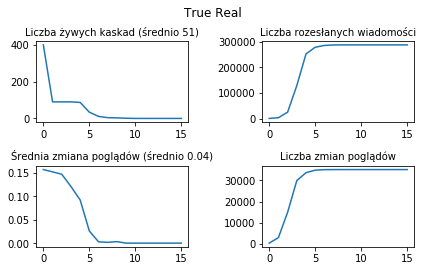

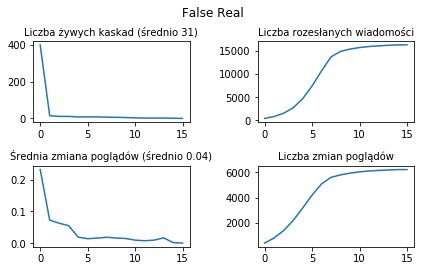

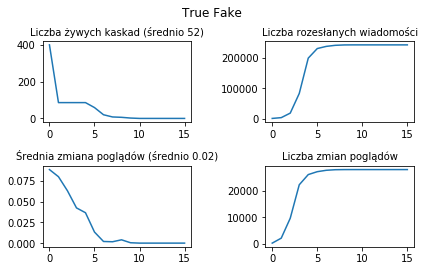

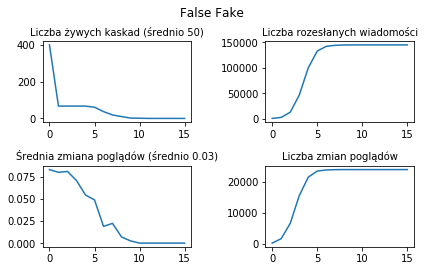

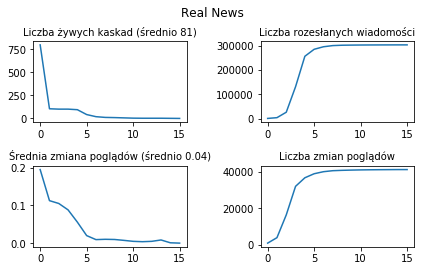

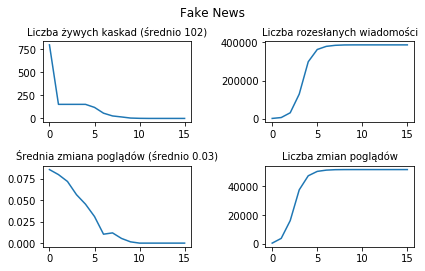

In [8]:
# rysowanie wykresów

results = {'True Real':{'cascades':np.zeros(iter+1), 'sent':np.zeros(iter+1), 'influence':np.zeros(iter+1), 'inflCnt':np.zeros(iter+1)},
          'False Real':{'cascades':np.zeros(iter+1), 'sent':np.zeros(iter+1), 'influence':np.zeros(iter+1), 'inflCnt':np.zeros(iter+1)},
          'True Fake':{'cascades':np.zeros(iter+1), 'sent':np.zeros(iter+1), 'influence':np.zeros(iter+1), 'inflCnt':np.zeros(iter+1)},
          'False Fake':{'cascades':np.zeros(iter+1), 'sent':np.zeros(iter+1), 'influence':np.zeros(iter+1), 'inflCnt':np.zeros(iter+1)}}
  
for news in newsList:
  if type(news) == RealNews and news.claim == facts[news.id]:
    key = 'True Real'
  elif type(news) == RealNews and news.claim != facts[news.id]:
    key = 'False Real'
  elif type(news) == FakeNews and news.claim == facts[news.id]:
    key = 'True Fake'
  else:
    key = 'False Fake'
  
  results[key]['cascades'] = news.nAliveCascades[:-1] + results[key]['cascades']
  cnts = [sum(x) for x in zip(*[cascade.cnt for cascade in news.cascades])]
  results[key]['sent'] = cnts[:-1] + results[key]['sent']
  results[key]['influence'] = news.influence + results[key]['influence']
  results[key]['inflCnt'] = news.influenceCnt + results[key]['inflCnt']
  
for key in results.keys(): 
  results[key]['influence'] = np.divide(results[key]['influence'], nFacts)

results['Real News'] = {'cascades': results['True Real']['cascades'] + results['False Real']['cascades'],
                        'sent': results['True Real']['sent'] + results['False Real']['sent'],
                        'influence': np.divide(results['True Real']['influence'] + results['False Real']['influence'], 2),
                        'inflCnt': results['True Real']['inflCnt'] + results['False Real']['inflCnt']}
results['Fake News'] = {'cascades': results['True Fake']['cascades'] + results['False Fake']['cascades'],
                        'sent': results['True Fake']['sent'] + results['False Fake']['sent'],
                        'influence': np.divide(results['True Fake']['influence'] + results['False Fake']['influence'], 2),
                        'inflCnt': results['True Fake']['inflCnt'] + results['False Fake']['inflCnt']}
  
for key in results.keys():  
  axes = plt.subplot(2, 2, 1)
  plt.plot(np.arange(0,iter+1), results[key]['cascades'])  
  axes.set_title('Liczba żywych kaskad (średnio ' + str(int(round(np.mean(results[key]['cascades'])))) + ')', size = 'medium')
    
  axes = plt.subplot(2, 2, 2)
  plt.plot(np.arange(0,iter+1), results[key]['sent'])  
  axes.set_title('Liczba rozesłanych wiadomości', size = 'medium')
    
  axes = plt.subplot(2, 2, 3)
  plt.plot(np.arange(0,iter+1), results[key]['influence']) 
  axes.set_title('Średnia zmiana poglądów (średnio ' + str(round(np.mean(results[key]['influence']), 2)) + ')', size = 'medium')
    
  axes = plt.subplot(2, 2, 4)
  plt.plot(np.arange(0,iter+1), results[key]['inflCnt']) 
  axes.set_title('Liczba zmian poglądów', size = 'medium')
  
  plt.suptitle(key)
  plt.tight_layout(rect=[0, 0.05, 1, 0.95])
  plt.show()